In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importar data

In [463]:
xls = pd.ExcelFile('estaturas.xlsx')

data = pd.read_excel(xls,'normales')
test = pd.read_excel(xls,'valtest(normales)')
anomalias = pd.read_excel(xls,'anomalias')
data.head()

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


In [467]:
data.shape
data = np.array(data)
test = np.array(test)
anomalias = np.array(anomalias)
y_anom = -np.ones(len(anomalias))

### Clusterin KMeans con NUMPY

In [4]:
#calcular las distancias
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1-x2)#np.sqrt(np.sum((x1 - x2)**2))

In [5]:
class K_Means():
    def __init__(self,K,max_iters):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        self.labels = []
        self.score = 0
    
    def predict(self,X):
        labels = np.empty(len(X))
        clusters = [[] for _ in range(self.K)]
        for idx,sample in enumerate(X):
            dist = [euclidean_distance(sample, point) for point in self.centroids]
            index_c = np.argmin(dist)
            clusters[index_c].append(idx)
            labels[idx]=index_c
        return labels
    
    def fit(self, X):
        np.random.seed(21)
        self.X = X
        # initialize centroids 
        random_sample_idxs = np.random.choice(len(X), self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        
        for _ in range(self.max_iters):
            self.clusters = self._create_clusters(self.centroids)
            old_centroids = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            if self._is_converged(old_centroids, self.centroids):
                print("converged in iteration "+str(_))
                break
             
        self.labels = self._set_labels(self.clusters)
        self.score = self._score(self.centroids)
            
    def _set_labels(self, clusters):
        labels = np.empty(len(self.X))
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels
            
    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    
    def _closest_centroid(self, sample, centroids):
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index
    
    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.X.shape[1]))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    
    def _is_converged(self, centroids_old, centroids):
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def _score(self,centroids):
        scores = []
        for k in range(self.K):
            puntos = self.X[self.labels==k]
            score = euclidean_distance(puntos,centroids[k])**2
            scores.append(score)
        return sum(scores)

### Eligiendo el k optimo

### Método del codo

Es un método para elegir el k optimo de cluster. Una forma de hacerlo es medir las distancias intraclusters, es decir para cada uno de los puntos del cluster, medimos la distancia de estos al centroide respectivo y las elevamos al cuadrado. Esto nos mide la variancia entre los puntos internos de un mismo cluster.

Suele haber un punto donde hay una variación maxima donde deja de decrecer la curva y pasa a estabilizarse.

In [436]:
k_numbers = 10
scores_points = []
for k in range(1,k_numbers):
    c = K_Means(k,50)
    c.fit(np.array(data))
    scores_points.append([c.score,k])

converged in iteration 1
converged in iteration 3
converged in iteration 1
converged in iteration 2
converged in iteration 1
converged in iteration 1
converged in iteration 2
converged in iteration 2
converged in iteration 2


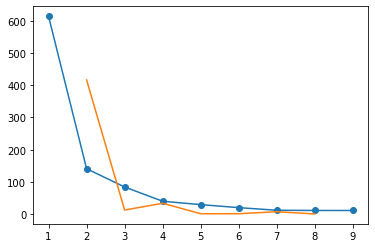

El número óptimo de cluster es 2


In [437]:
scores_a = np.array(scores_points)
plt.plot(scores_a[:,1], scores_a[:,0],marker="o")

acc_rev = np.diff(scores_a[:,0],2)
plt.plot(scores_a[:,1][:-2]+1, acc_rev)
plt.show()
k = acc_rev.argmax() +2
print("El número óptimo de cluster es %s"%str(k))

### Graficando el mejor cluster.

Segun el metodo del codo en este caso en terminos de complejidad se observa que despues del cluster k=2 la distancia es minima, entonces podemos definir nuestro k optimo como k=2

Se observa que la variación de las distancias de 2 a 3 es minima, por lo cual se puede considerar como un k optimo.

para este problema el metodo del codo, es efectivo.

In [438]:
def getColors(labels):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    return [colors[int(l)] for l in labels]

In [439]:
k=2
cluster = K_Means(k,50)
cluster.fit(data)

labels = cluster.labels
centroids = cluster.centroids
cluster.score
labels_test = cluster.predict(test)

converged in iteration 3


In [440]:
np.unique(labels)

array([0., 1.])

In [441]:
def plot(data,centroids,test,labels,labels_test):
    plt.figure(figsize=(10,8))
    plt.scatter(data[:,0],data[:,1],c=getColors(labels),cmap="jet",label="data")
    plt.scatter(centroids[:,0],centroids[:,1],s=150, c='black', marker="X",label="centroids")
    plt.scatter(test[:,0],test[:,1],s=50,c=getColors(labels_test), marker="s",label="new predictions")
    
    for i,c in enumerate(centroids):
        plt.text(c[0], c[1], str(i), color=getColors([i])[0], fontsize=20,weight="bold")
    
    
    plt.title("Clustering")
    plt.xlabel("Estatura")
    plt.ylabel("Edad")
        
    plt.legend()

    plt.show()  

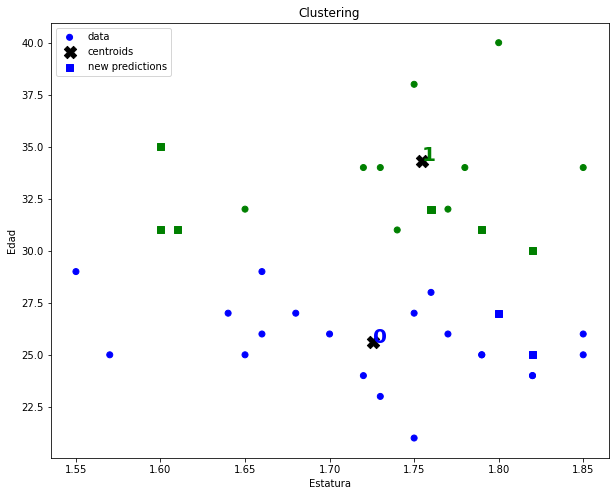

In [442]:
plot(data,centroids,test,labels,labels_test)

### Clustering con sklearn GaussianMixture GMM

In [443]:
from sklearn import mixture

In [444]:
np.random.seed(300)
gmm = mixture.GaussianMixture(n_components=k)
model = gmm.fit(data)

In [445]:
proba_gmm = model.predict_proba(data)
pred_gmm = model.predict(data)
pred_test_gmm = model.predict(test)
proba_tests = model.predict_proba(test)

In [446]:
#creando dataset para probabilidades
data_probs = pd.DataFrame(test,columns=["estatura","edad"])
data_probs["cluster_gmm"] = pred_test_gmm
clusters_gmm = np.unique(pred_gmm)

for c in clusters_gmm:
    data_probs["prob cluster "+str(c)] = np.round(proba_tests[:,c] * 100,2)
data_probs

,estatura,edad,cluster_gmm,prob cluster 0,prob cluster 1
0,1.82,25.0,1,0.02,99.98
1,1.80,27.0,1,1.13,98.87
2,1.60,31.0,1,37.33,62.67
3,1.60,35.0,0,99.82,0.18
4,1.82,30.0,0,81.84,18.16
5,1.76,32.0,0,99.83,0.17
6,1.79,31.0,0,98.43,1.57
7,1.61,31.0,1,48.69,51.31


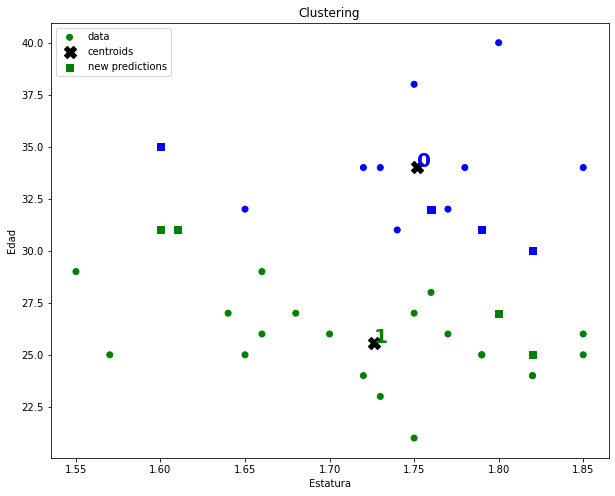

In [460]:
plot(data,model.means_,test,pred_gmm,pred_test_gmm)

### Conclusiones

In [455]:
#centroides
print("centroides k means cluster 0:", cluster.centroids[0])
print("centroides k means cluster 1:", cluster.centroids[1])
print("centroides gmm cluster 0:", model.means_[1])
print("centroides gmm cluster 1:", model.means_[0])

centroides k means cluster 0: [ 1.7255 25.6   ]
centroides k means cluster 1: [ 1.75444444 34.33333333]
centroides gmm cluster 0: [ 1.72627184 25.55881686]
centroides gmm cluster 1: [ 1.75156703 34.03538488]


Ambos metodos muestran una clasificación de los clusters similar, por lo que el problema es adecuado resolverlo con un k optimo de 2, tambien observamos que los centroides son similares, asi como la clasificación de los nuevos datos.

analizando los centroides se observa que se pueden agrupar por edad, con una distribución de estaturas de forma similar.

* personas con estaturas de 1.55 a 1.85, aproximadamente en un rango de edad de 21 a 30 años.
* personas con estaturas de 1.55 a 1.85, aproximadamente en un rango de edad de 31 a 40 años.

### Detección de Anomalias

In [468]:
from scipy.stats import multivariate_normal

In [469]:
class AnomalyDetection():
    def __init__(self):
        self.means = np.array([])
        self.sigma = np.array([])
        self.variances = np.array([])
    
    def fit(self, X):
        self.means = np.mean(X,axis=0)
        self.sigma = np.cov(X.T)
        self.variances = np.var(X,axis=0)
    
    def predict(self,X):
        p = multivariate_normal(mean=self.means,cov=self.sigma)
        return p.pdf(X)
    
    def predict_norm(self,X):
        proba = [np.prod( self.pdf(x) ) for x in X]#probar univariable
        return np.array(proba)
    
    #función pdf para nomral
    def pdf(self,x):
        numerator = np.exp(- (x-self.means)**2 / (2 * self.variances))
        denominator = np.sqrt(2 * np.pi * self.variances)
        return numerator / denominator

In [470]:
anomaly = AnomalyDetection()
anomaly.fit(data)#entrenando modelo

## Evaluando modelo detección de anomalias

In [471]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [472]:
#construyendo dataset de pruebas y validación con las anomalías
new_t = np.hstack((test, np.ones((len(test), 1))))
new_a = np.hstack((anomalias, -np.ones((len(anomalias), 1))))

In [473]:
new_data_t = np.vstack((new_t,new_a))

In [474]:
x_test = new_data_t[:,[0, 1]]
y_test = new_data_t[:,2]

In [475]:
#dividiendo data
np.random.seed(300)
Xvalid,Xtest,Yvalid,Ytest = train_test_split(x_test,y_test,test_size=0.5)

In [476]:
#predicciones, probabilidades
pred_valid = anomaly.predict(Xvalid) #multivariate gaussian
pred_valid_norm = anomaly.predict_norm(Xvalid)#noraml
print(pred_valid)
print(pred_valid_norm)

[0.29541885 0.0293934  0.         0.30826203 0.         0.2892867 ]
[0.29229206 0.03380835 0.         0.30894149 0.         0.30049813]


### Seleccionando el mejor empsilon con f1_score como metrica

con set de validacion

In [477]:
epsilons = [0.01, 0.02, 0.05, 0.1,0.15,0.2,0.25]
for e in epsilons:
    correct_preds = np.where(pred_valid < e, -1, 1)
    print(e,'=  f1_score:', metrics.f1_score(Yvalid,correct_preds))

0.01 =  f1_score: 1.0
0.02 =  f1_score: 1.0
0.05 =  f1_score: 0.8571428571428571
0.1 =  f1_score: 0.8571428571428571
0.15 =  f1_score: 0.8571428571428571
0.2 =  f1_score: 0.8571428571428571
0.25 =  f1_score: 0.8571428571428571


In [478]:
##mejor epison 0.01, o 0.02
pred_test = anomaly.predict(Xtest)
correct_preds_t = np.where(pred_test < 0.01, -1, 1)

In [479]:
metrics.f1_score(Ytest,correct_preds_t)

1.0

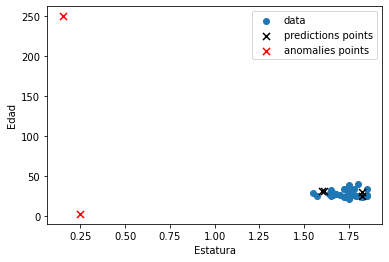

In [480]:
## Graficando datos de test
point_a_t = Xtest[np.where(correct_preds_t == -1)]
point_t = Xtest[np.where(correct_preds_t == 1)]
plt.scatter(data[:,0],data[:,1],label="data")
plt.scatter(point_t[:,0],point_t[:,1],s=50, c="black",marker="x",label="predictions points")
plt.scatter(point_a_t[:,0],point_a_t[:,1],s=50, c="r",marker="x",label="anomalies points")
plt.legend()
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.show()

### Conslusiones 

Se observa que el algoritmo, clasifico muy bien las anomalias para este problema, nuestra metrica de interés es lo que esperabamos, dado que los datos son pocos.